# Single-group Segregation Indices

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p segregation,geopandas,libpysal,pandana

Author: eli knaap

Last updated: 2021-05-11

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.23.1

segregation: 2.0.0
geopandas  : 0.9.0
libpysal   : 4.3.0
pandana    : 0.6.1



Single-group indices are calculated using the `singlegroup` module

### Data Prep

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.examples import load_example

In [3]:
# read in sacramento data from libpysal and reproject into an appropriate CRS
sacramento = gpd.read_file(load_example("Sacramento1").get_path("sacramentot2.shp"))
sacramento = sacramento.to_crs(sacramento.estimate_utm_crs())

In [4]:
sacramento.head()

,FIPS,MSA,TOT_POP,POP_16,POP_65,WHITE,BLACK,ASIAN,HISP,MULTI_RA,...,EMP_FEM,OCC_MAN,OCC_OFF1,OCC_INFO,HH_INC,POV_POP,POV_TOT,HSG_VAL,POLYID,geometry
0,06061022001,Sacramento,5501,1077,518,4961,29,82,336,31,...,1187,117,663.0,42,52941,5461,470,225900,1,"POLYGON ((740409.853 4338451.728, 740199.864 4..."
1,06061020106,Sacramento,2072,396,109,1603,0,28,391,41,...,522,38,229.0,19,51958,2052,160,249300,2,"POLYGON ((753400.378 4347151.080, 753395.816 4..."
2,06061020107,Sacramento,3633,911,126,1624,9,0,1918,41,...,698,86,197.0,0,32992,3604,668,175900,3,"POLYGON ((758318.262 4352123.456, 758319.774 4..."
3,06061020105,Sacramento,1683,281,154,1564,0,55,60,4,...,519,5,256.0,6,54556,1683,116,302300,4,"POLYGON ((750839.595 4342678.807, 750805.840 4..."
4,06061020200,Sacramento,5794,1278,830,5185,17,13,251,229,...,1260,155,506.0,59,50815,5771,342,167300,5,"POLYGON ((670062.020 4311030.409, 670133.819 4..."


<AxesSubplot:>

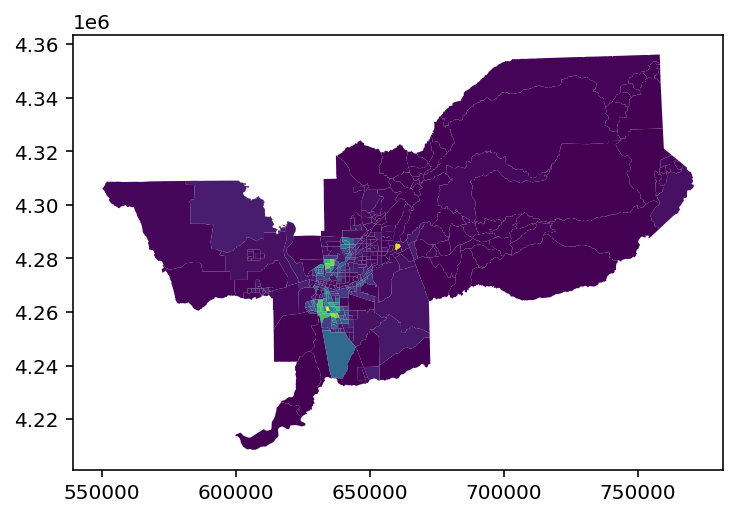

In [5]:
sacramento.plot('BLACK')

## Aspatial Segregation Indices

To compute an aspatial segregation index, pass a dataframe, a group population variable, and total population variable to the index's class

In [6]:
from segregation.singlegroup import Dissim

In [7]:
dissim = Dissim(sacramento, group_pop_var='BLACK', 
                total_pop_var='TOT_POP')

The `statistic` attribute holds the value of the segregation index, and the `data` attribute holds the data used to calculate the index

In [8]:
dissim.statistic

0.4883394024705785

In [9]:
dissim.data.head()

,BLACK,TOT_POP,geometry
0,29,5501,"POLYGON ((740409.853 4338451.728, 740199.864 4..."
1,0,2072,"POLYGON ((753400.378 4347151.080, 753395.816 4..."
2,9,3633,"POLYGON ((758318.262 4352123.456, 758319.774 4..."
3,0,1683,"POLYGON ((750839.595 4342678.807, 750805.840 4..."
4,17,5794,"POLYGON ((670062.020 4311030.409, 670133.819 4..."


## Spatial Segregation Indices

For calculating spatial segregation indices, the package implements two classes of indices: spatially-explicit and spatially-implicit. 

Spatially-explicit indices are those for which space was a formal consideration in the index's original formulation, whereas spatially-implicit indices are developed using the logic of [Reardon and O'Sulivan](http://doi.wiley.com/10.1111/j.0081-1750.2004.00150.x). 

For the latter,(otherwise called *generalized* spatial segregation indices) the package can incorporate spatial relationships represented by either a [`libpysal.W`](https://pysal.org/libpysal/api.html) weights object or a [`pandana.Network`](http://udst.github.io/pandana/network.html) network object, which means generalized spatial segregation indices can be computed according to many different spatial relationships which could include contiguity, distance, or network connectivity. This flexibility is particularly useful for specifying appropriate "neighborhood" definitions for different types of input data (which could be, e.g. housing units, census tracts, or counties)

For spatially-explicit indices, they can be called like any other, though some may have additional arguments:

In [10]:
from segregation.singlegroup import AbsoluteCentralization, Gini

In [11]:
cent = AbsoluteCentralization(sacramento, group_pop_var='BLACK', 
                              total_pop_var='TOT_POP')

In [12]:
cent.statistic

0.8491771822066525

### Euclidian distance based measures

For generalized spatial indices, a `distance` parameter can be passed to the index of choice. Under the hood, the input data will be passed through a kernel function with the distance parameter as the kernel bandwidth.

(note in this case because the CRS of the sacramento dataframe is UTM, the units are in meters)

In [13]:
# aspatial gini index
aspatial_gini = Gini(sacramento, group_pop_var='BLACK', 
                     total_pop_var='TOT_POP')

In [14]:
# generalized spatial gini index
gen_spatialgini = Gini(sacramento, group_pop_var='BLACK', 
                       total_pop_var='TOT_POP', distance=2000)

In [15]:
gen_spatialgini.statistic

0.5368102768280784

In [16]:
aspatial_gini.statistic

0.6361755332635235

Examining the `data` attribute of the fitted index shows how the input data are transformed

<AxesSubplot:>

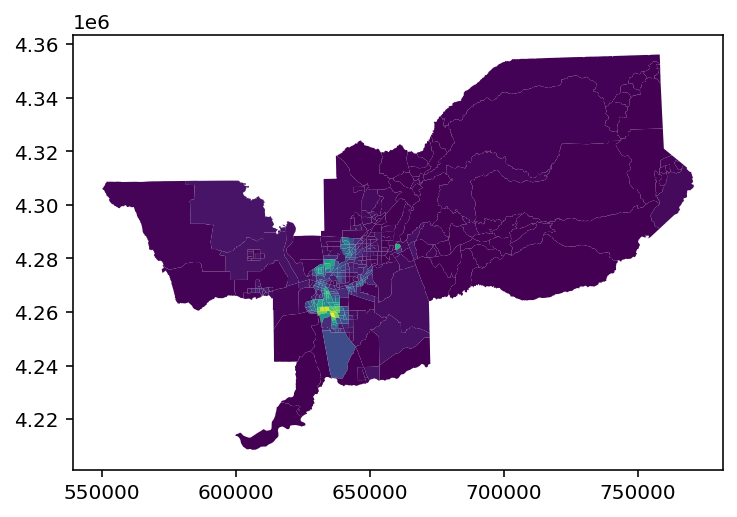

In [17]:
# kernelized data
gen_spatialgini.data.plot('BLACK')

<AxesSubplot:>

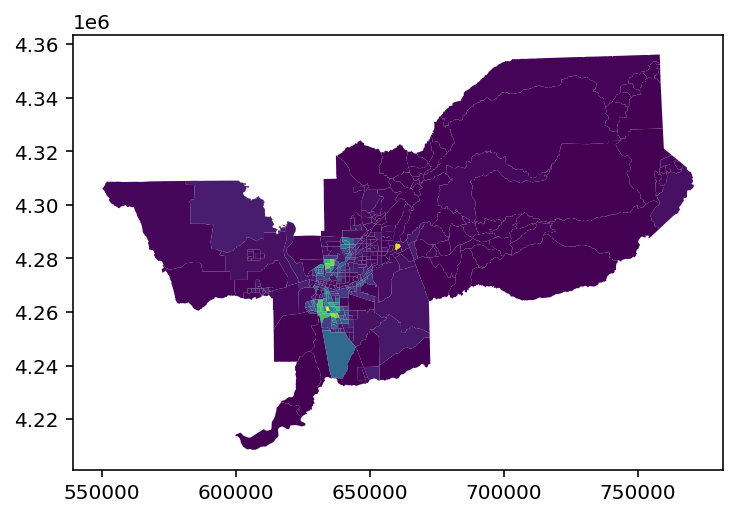

In [18]:
# original data
sacramento.plot('BLACK')

### Network distance based measures

Instead of a euclidian distance-based kernel, each generalized spatial segregation index can be calculated using accssibility analysis on a transportation network instead. Since people can't fly, using a travel network to measure spatial distances is more conceptually pure to the spirit of segregation indices 

In [19]:
import pandana as pdna

A network can be created using the [urbanaccess](https://github.com/UDST/urbanaccess) package, or the built-in `get_osm_network` function from the `segregation.util` module. Alternatively, metropolitan-scale networks from OpenStreetMap are also available in the [CGS quilt bucket](https://open.quiltdata.com/b/spatial-ucr/tree/osm/) (named by CBSA FIPS code)

In [20]:
net = pdna.Network.from_hdf5('../40900.h5')

In [21]:
network_spatialgini = Gini(sacramento, group_pop_var='BLACK', 
                           total_pop_var='TOT_POP', distance=2000, 
                           network=net, decay='linear')

Comparing spatial gini indices based on straight-line distance versus network distance:

In [22]:
network_spatialgini.statistic

0.5848616778202473

In [23]:
gen_spatialgini.statistic

0.5368102768280784

The segregation statistic using network distance to construct neighborhoods is higher than using the one using unrestricted euclidian distance

## Batch-Computing Single-Group Measures

To compute all single group indices in one go, the package provides a wrapper function in the `batch` module

In [24]:
from segregation.batch import batch_compute_singlegroup

In [25]:
all_singlegroup = batch_compute_singlegroup(sacramento, group_pop_var='BLACK', total_pop_var='TOT_POP')

In [26]:
all_singlegroup

,Statistic
Name,
AbsoluteCentralization,0.849177
AbsoluteClustering,0.117545
AbsoluteConcentration,0.981443
Atkinson,0.365947
BiasCorrectedDissim,0.487689
BoundarySpatialDissim,0.450074
ConProf,0.112752
CorrelationR,0.101027
Delta,0.907277
